GEANT4 : Loading modules
GEANT4 : Loading complete.
GEANT4 : Imported all definitions.

**************************************************************
 Geant4 version Name: geant4-11-02-patch-02 [MT]   (21-June-2024)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

<<< Geant4 Physics List simulation engine: QGSP_BERT

Available UI session types: [ tcsh, csh ]
### Adding tracking cuts for neutron  TimeCut(ns)= 10000  KinEnergyCut(MeV)= 0

-------- WWWW ------- G4Exception-START -------- WWWW -------
*** G4Exception : GeomNav1002
      issued by : G4Navigator::ComputeStep()
Stuck Track: potential geometry or navigation problem.
  Track stuck, not moving for 10 steps.
  Current  phys 

/usr/local/lib/python3.9/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "uint32" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

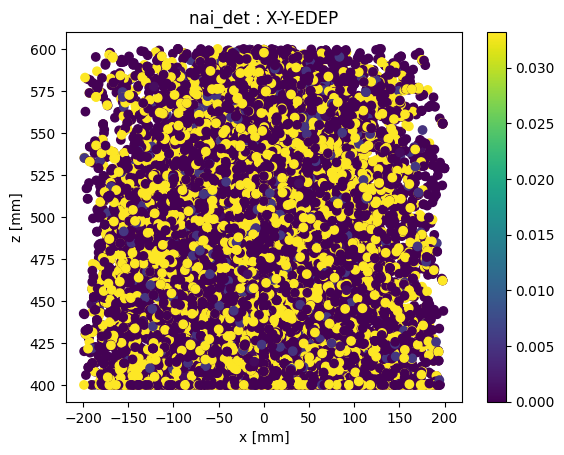

FINISHED


In [1]:
#!/usr/bin/env python
# coding: utf-8
# In[1]:
import pandas as pd
import matplotlib.pyplot as plt

import g4ppyy as g4
from g4ppyy import mm, cm, m, eV, MeV, GeV, deg, twopi

import random

gRunManager = g4.G4RunManager();

class custom_generator(g4.G4VUserPrimaryGeneratorAction):
    "Flat Energy Spectrum Upward Neutron Generator"
    def __init__(self):
        super().__init__()
        self.particle = g4.G4Neutron.Definition()
        self.particleGun = g4.G4ParticleGun()
        self.particleGun.SetParticleDefinition(self.particle)
        self.particleGun.SetParticleMomentumDirection(g4.G4ThreeVector(0, 0, +1))
        self.particleGun.SetParticlePosition(g4.G4ThreeVector(0.0,0.0,0.0))
        self.particleGun.SetNumberOfParticles(1)  
        self.particleGun.SetParticleTime(0)

    def GeneratePrimaries(self, anEvent):
        energy = random.random() * 20 * MeV
        self.particleGun.SetParticleEnergy(energy)  
        self.particleGun.GeneratePrimaryVertex(anEvent)


# In [3]: NEUTRON DETECTOR
# Make a ND array to store neutron energy

class gamma_energy_store(g4.G4VSensitiveDetector):

    def Reset(self):
        self.gamma_event = {
            "eid": [],
            "pid": [],
            "ke": [],
            "edep": [],
            "x": [],
            "y": [],
            "z": [],
        }
                
    def ProcessHits(self, aStep, ROhist):
        
        pdg = (aStep.GetTrack().GetParticleDefinition().GetPDGEncoding())
        if not (pdg == 22): return 0 # gamma requirement

        # Get Before
        eid = int(gRunManager.GetCurrentEvent().GetEventID())
        pid = int(aStep.GetTrack().GetTrackID())
        pos = aStep.GetPreStepPoint().GetPosition() 
        ke = aStep.GetPreStepPoint().GetKineticEnergy() 
        edep = aStep.GetTotalEnergyDeposit()
        
        self.gamma_event["eid"].append(eid)
        self.gamma_event["pid"].append(pid)
        self.gamma_event["ke"].append(ke)
        self.gamma_event["edep"].append(edep)
        self.gamma_event["x"].append(pos.x())
        self.gamma_event["y"].append(pos.y())
        self.gamma_event["z"].append(pos.z())
        
        return 1

    def StartOfRunAction(self):
        self.Reset()

    def EndOfRunAction(self):
        self.df = pd.DataFrame(data=self.gamma_event)

    def VisualizationAction(self):
        plt.scatter(self.df.x, self.df.z, c=self.df.edep)
        plt.title(str(self.GetName()) + " : X-Y-EDEP")
        plt.xlabel("x [mm]")
        plt.ylabel("z [mm]")
        plt.colorbar()
        plt.show()
                


# In[3]: BUILD A WORLD consisting of AIR with a HDPE tube around source.
class custom_world(g4.G4VUserDetectorConstruction):   
    
    def BuildWorld(self):
        # Mother Box
        self.world = g4.build_component("world", solid="box", x=5*m, y=5*m, z=5*m, material="G4_AIR")

        # Moderator thickness
        thickness = 1*cm
        
        # World Geometries
        self.sample = g4.build_component("sample", solid="tubs", 
                                         rmax=20*cm, z=10*cm/2, color=[0.1,1.0,0.1],
                                         mother=self.world, material="G4_C", pos=[0.0,0.0,+10*cm])
        self.nai_crystal = g4.build_component("nai", solid="tubs", 
                                              rmax=20*cm, z=20*cm/2, 
                                              mother=self.world, material="G4_SODIUM_IODIDE", pos=[0.0,0.0,+50*cm])
    
    def BuildDetectors(self):
        # Sensitive Volume Definitions
        self.nai_det = gamma_energy_store("nai_det")
        self.nai_crystal.GetLogicalVolume().SetSensitiveDetector(self.nai_det)
        g4.register_detector_hooks(detector.nai_det)

    def Construct(self):
        self.BuildWorld()
        self.BuildDetectors()
        
        # Return the mother
        return self.world # top mother volume

    
# In [4]:
# Add Physics List
physics = g4.QGSP_BERT()
gRunManager.SetUserInitialization(physics)

# Add a World
detector = custom_world()
gRunManager.SetUserInitialization(detector)

# Add a Generator
gen = custom_generator()
gRunManager.SetUserAction(gen)

# Add standard GEANT4 Actions
g4.add_default_actions(gRunManager)

# Setup vis to check geometry (optioonal)
g4.create_visualization(gRunManager)

# Generate some events
g4.handle_beam(gRunManager, 10000)

# Draw the vis plot (optional)
g4.draw_visualization(gRunManager)

print("FINISHED")



In [2]:
locals()

{'__name__': '__main__',
 '__doc__': 'Automatically created module for IPython interactive environment',
 '__package__': None,
 '__loader__': None,
 '__spec__': None,
 '__builtin__': <module 'builtins' (built-in)>,
 '__builtins__': <module 'builtins' (built-in)>,
 '_ih': ['',
  '#!/usr/bin/env python\n# coding: utf-8\n# In[1]:\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\nimport g4ppyy as g4\nfrom g4ppyy import mm, cm, m, eV, MeV, GeV, deg, twopi\n\nimport random\n\ngRunManager = g4.G4RunManager();\n\nclass custom_generator(g4.G4VUserPrimaryGeneratorAction):\n    "Flat Energy Spectrum Upward Neutron Generator"\n    def __init__(self):\n        super().__init__()\n        self.particle = g4.G4Neutron.Definition()\n        self.particleGun = g4.G4ParticleGun()\n        self.particleGun.SetParticleDefinition(self.particle)\n        self.particleGun.SetParticleMomentumDirection(g4.G4ThreeVector(0, 0, +1))\n        self.particleGun.SetParticlePosition(g4.G4ThreeVector(0.0,0.0,0.0

In [3]:
detector.nai_det.df

,eid,pid,ke,edep,x,y,z
0,4,4,0.763326,0.033176,-29.732399,32.250305,516.012392
1,4,3,2.600810,0.000000,-29.732399,32.250305,516.012392
2,4,3,0.329046,0.033176,-12.400811,33.505136,537.942400
3,4,10,0.062291,0.033176,-11.818144,33.740203,538.272036
4,4,9,0.490166,0.000000,-12.201814,33.531712,538.147221
...,...,...,...,...,...,...,...
28294,9996,4,1.022534,0.000000,-5.291666,-3.846706,441.752763
28295,9996,4,0.868616,0.000000,-18.559139,-20.033289,447.237139
28296,9996,4,0.320595,0.000000,-19.413448,-22.966973,447.559703
28297,9996,4,0.167414,0.000000,-13.324507,-26.094142,434.454077


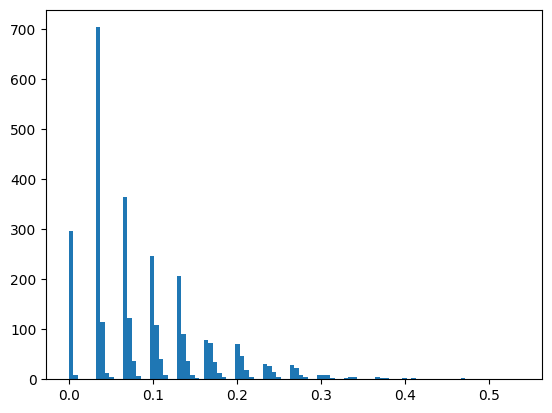

      pid         ke      edep            x            y             z
eid                                                                   
4     306  16.747677  0.210380  -572.751152  -962.624456   9087.116320
5      25   0.041353  0.033176   -26.887532   -53.223977    400.000000
7      96   5.852015  0.132704   410.930602   207.620428   4807.015775
12     19   0.037846  0.033176   -44.650738   151.170185    400.000000
16     12   0.389538  0.066352    14.011047  -178.626042    800.000000
...   ...        ...       ...          ...          ...           ...
9982  149  12.898579  0.067430 -1709.010173  1188.491079   8116.199388
9984   13   8.232396  0.066352   258.714660    10.216438   2771.337985
9985   34   6.949977  0.067233   -33.461738    14.215861   3276.605208
9989  106  10.901891  0.105801  -108.816499   286.422102  10145.876095
9996   57   6.082475  0.071547   -87.273480   -51.027429   4831.799542

[2974 rows x 6 columns]


In [4]:
vals = detector.nai_det.df.groupby("eid").sum()
plt.hist(vals.edep, bins=100)
plt.show()
print(vals)